# Influenza-Like Illnesses (ILI) Estimation with Atipan Data

[WHO defines ILI](https://www.who.int/teams/global-influenza-programme/surveillance-and-monitoring/case-definitions-for-ili-and-sari)  as "acute respiratory infection with: measured fever of ≥38 ⁰C and cough with onset within the last 10 days." 

The objectives of this analysis are as follows:
1. Filter cases according to the following rules:
- Mention of 'URTI', 'Upper Respiratory Tract Infection', 'CAP', 'Community Acquired Pneumonia', 'PCAP', 'Pediatric Community Acquired Pneumonia', 'fever', 'cough', or 'colds' in the chief complaint, history of patient illness, and diagnosis fields.
- Body temperature >= 37.8 deg. C. 
2. Analyze the age and sex distribution of the cases.
3. Analyze the geographical distribution of the cases.
4. Analyze the temporal distribution of the cases.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline

In [2]:
df = pd.read_csv('view_2078.csv')
list(df.columns)

['id',
 'Date of Encounter',
 'Type of encounter',
 'Purpose of encounter',
 'Age Range at Consultation',
 'Is the patient wearing a face mask during the consulation?',
 'Encounter ID 2',
 'Retire Encounter Record?',
 'Reason for Retiring Record',
 'Is Archived?',
 'Date Archived',
 'First Created',
 'Last Updated',
 'Complaint/s',
 'History of Illness',
 'Image for Complaint/Hx',
 'Neurologic',
 'Other Neurologic',
 'Pulmonary',
 'Other Pulmonary',
 'Cardiovascular',
 'Other Cardiovascular',
 'Skin/Gland',
 'Other Skin/Gland',
 'Gastrointestinal',
 'Other Gastrointestinal',
 'Musculoskeletal',
 'Other Musculoskeletal',
 'Psychiatric',
 'Other Psychiatric',
 'Temperature (C)',
 'Blood Pressure',
 'Pulse Rate (bpm)',
 'Oxygenation (%)',
 'Respiratory Rate',
 'Height (cm)',
 'Weight (kg)',
 'BMI',
 'Eye response',
 'Verbal response',
 'Motor response',
 'GCS',
 'Skin Status',
 'Skin Findings',
 'HEENT Status',
 'HEENT Findings',
 'Cardiovascular System Status',
 'Cardiovascular System Fi

In [6]:
len(df)

7585

## Filtering Pipeline

In [3]:
class Step:
    def process(self):
        pass
        
class GreaterThanOrEqual(Step):
    def __init__(self, column, threshold):
        self.column = column 
        self.threshold = threshold 

    def process(self, df):
        df = df[df[self.column] >= self.threshold].copy(deep=True)
        return df 

class FilterKeyword(Step):
    def __init__(self, column, keyword):
        self.keyword = keyword
        self.column = column

    def process(self, df):
        return df[df[self.column].fillna('').apply(lambda x: self.keyword.strip().lower() in x.strip().lower())].copy(deep=True)

class PipelineBuilder:
    def __init__(self):
        self.steps = [] 
        
    def add_step(self, step):
        self.steps.append(step)

    def build(self):
        return self.steps 

In [4]:
columns = [
    'Complaint/s', 
    'History of Illness', 
    'Preliminary Diagnosis/Final Diagnosis'
]

keywords = [
    'URTI', 
    'Upper Respiratory Tract Infection', 
    'CAP', 
    'Community Acquired Pneumonia', 
    'PCAP', 
    'Pediatric Community Acquired Pneumonia', 
    'fever', 
    'cough',
    'colds' 
]

# Pipeline Builder
builder = PipelineBuilder() 
for column in columns:
    for keyword in keywords:
        builder.add_step(FilterKeyword(column, keyword))
builder.add_step(GreaterThanOrEqual('Temperature (C)', 37.8))

# Getting Dataframes per Filter: No dependency between steps
dataframes = [] 
for step in builder.build():
    dataframes.append(step.process(df)) 

# Merging Dataframes from each step
output = pd.DataFrame(columns=df.columns) 
for dataframe in dataframes:
    output = pd.concat([output,dataframe]) 

/tmp/ipykernel_138362/3065347826.py:34: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = pd.concat([output,dataframe])
/tmp/ipykernel_138362/3065347826.py:34: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = pd.concat([output,dataframe])
/tmp/ipykernel_138362/3065347826.py:34: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = pd.concat([output,dataframe])
/tmp/ipykernel_138362/3065347826.py:34: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = pd.concat([out

In [5]:
output.shape

(10404, 110)

In [6]:
output.to_csv('ILI_estimate.csv')

## Sex

In [7]:
output['Sex'].dropna().value_counts()

Female    5891
Male      4055
Name: Sex, dtype: int64

## Age

In [8]:
output['Age Range at Consultation'].value_counts()

0 - 9      5690
10 - 19    1405
20 - 29     779
30 - 39     658
60 - 69     531
50 - 59     475
40 - 49     461
70 - 79     226
80 - 89     150
100+         17
90 - 99      12
Name: Age Range at Consultation, dtype: int64

## Geographical Distribution

No geographical information.

## Temporal Distribution

### Daily

<AxesSubplot: >

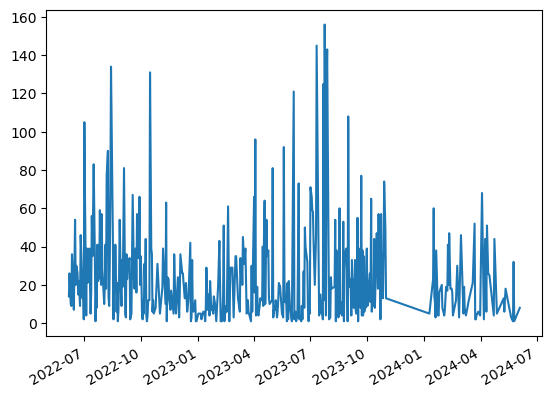

In [9]:
output['Date of Encounter'] = pd.to_datetime(output['Date of Encounter'])
output['Date of Encounter'].value_counts().sort_index().plot() 

### Weekly

In [10]:
year = output['Date of Encounter'].dt.isocalendar().year.astype(str)
week = output['Date of Encounter'].dt.isocalendar().week.astype(str)
output['year'] = year
output['week'] = week
output['year-week'] = year + "-" + week

In [11]:
start_date = pd.to_datetime('2022-07-01', format='%Y-%m-%d').tz_localize('UTC').tz_convert('Asia/Shanghai')  # Replace 'Asia/Shanghai' with your timezone
end_date = pd.to_datetime('2023-06-30', format='%Y-%m-%d').tz_localize('UTC').tz_convert('Asia/Shanghai')  # Replace 'Asia/Shanghai' with your timezone

start_date, end_date

(Timestamp('2022-07-01 08:00:00+0800', tz='Asia/Shanghai'),
 Timestamp('2023-06-30 08:00:00+0800', tz='Asia/Shanghai'))

In [12]:
# Filter the DataFrame
filtered_output = output[(output['Date of Encounter'] >= start_date) & (output['Date of Encounter'] <= end_date)]

In [13]:
filtered_output.head()

,id,Date of Encounter,Type of encounter,Purpose of encounter,Age Range at Consultation,Is the patient wearing a face mask during the consulation?,Encounter ID 2,Retire Encounter Record?,Reason for Retiring Record,Is Archived?,...,Patient Disposition Summary,Type of Consultation,Income Classification,Follow-up Schedule,Identifying Physical Qualities,Record ID,Sex,year,week,year-week
121,6476ec7b6ce4200026d33508,2023-05-19 00:00:00+08:00,Outpatient,Check-up,0 - 9,False,4590-jVavTFGn1L,False,NaN,False,...,Released | | | Did the patient get well:,NaN,NaN,2023-05-31T00:00:00+08:00,NaN,4590,Male,2023,20,2023-20
134,62f9dfa72fc3aa002183b080,2022-08-12 00:00:00+08:00,Outpatient,Check-up,0 - 9,False,1639-mtJzy8EbWo,False,NaN,False,...,Need to follow up | | | Did the patient get ...,NaN,NaN,2022-08-15T00:00:00+08:00,NaN,1639,Female,2022,32,2022-32
154,63b635a716af47001280e3d6,2022-12-19 00:00:00+08:00,Outpatient,Check-up,0 - 9,False,2944-rGPpjO2NG7,False,NaN,False,...,Need to follow up | | | Did the patient get ...,NaN,NaN,2023-01-05T00:00:00+08:00,NaN,2944,Male,2022,51,2022-51
155,63367f8d95dbbd0022dd9bd2,2022-09-24 00:00:00+08:00,Outpatient,Other,0 - 9,False,2226-eh7frfePHH,False,NaN,False,...,Released | | | Did the patient get well:,NaN,NaN,2022-09-30T00:00:00+08:00,NaN,2226,Male,2022,38,2022-38
230,635e0625734ab900224e7dee,2022-10-21 00:00:00+08:00,Outpatient,Check-up,0 - 9,False,2578-oTnROqgNX0,False,NaN,False,...,Released | | | Did the patient get well:,NaN,NaN,2022-10-30T00:00:00+08:00,NaN,2578,Female,2022,42,2022-42


In [14]:
weekly = filtered_output['year-week'].value_counts().sort_index()

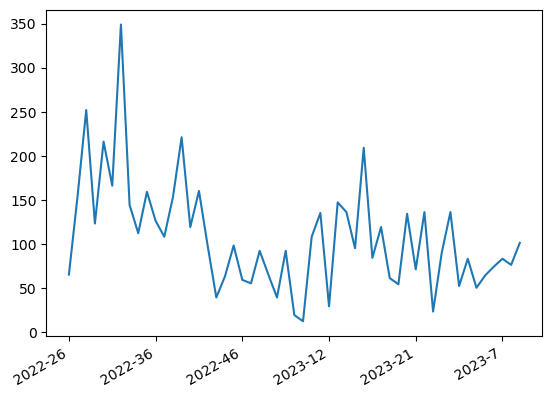

In [15]:
weekly.plot() 
plt.gcf().autofmt_xdate()

plt.show()

### Weekly (Smoothed)

Reference: [How to Plot a Smooth Curve in Matplotlib?](https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/)

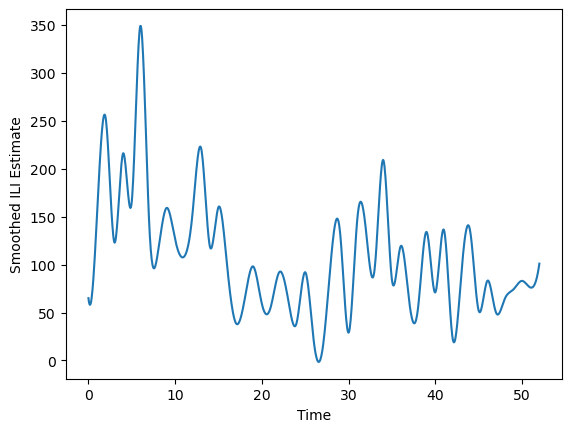

In [16]:
# Dataset
x = weekly.reset_index().index
y = weekly.values
 
X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 1000)
Y_ = X_Y_Spline(X_)

plt.plot(X_, Y_)
plt.xlabel("Time")
plt.ylabel("Smoothed ILI Estimate")
plt.show()

/tmp/ipykernel_135/1311121952.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(x_labels_main[::4]))
/tmp/ipykernel_135/1311121952.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.xaxis.set_major_formatter(plt.FixedFormatter(x_labels_secondary[::4]))


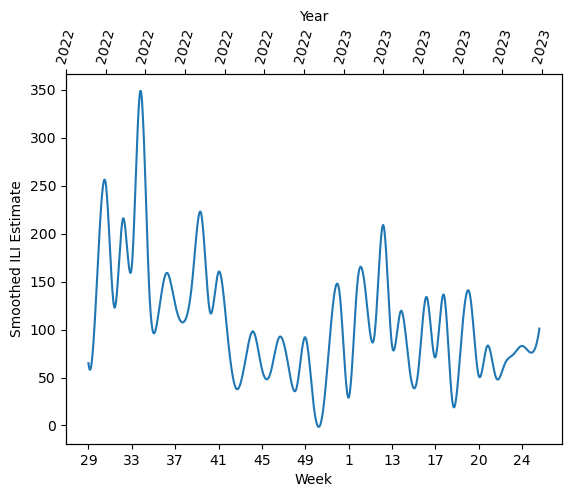

In [17]:
import matplotlib.ticker as ticker

weekly = filtered_output['year-week'].value_counts().sort_index()

x = weekly.reset_index().index
y = weekly.values

X_Y_Spline = make_interp_spline(x, y)

# Returns evenly spaced numbers over a specified interval.
X_ = np.linspace(x.min(), x.max(), 1000)
Y_ = X_Y_Spline(X_)

x_ticks = np.linspace(x.min(), x.max(), len(weekly.index)+1)
x_labels = [str(weekly.index[int(i)] if i < len(weekly.index) else weekly.index[-1]) for i in x_ticks]

# Split the year and the decimal part
x_labels_main = [label.split('-')[1] for label in x_labels]
x_labels_secondary = [label.split('-')[0] for label in x_labels]

fig, ax = plt.subplots()

# Plot your data
ax.plot(X_, Y_)

ax.xaxis.set_major_locator(plt.MaxNLocator(len(x_labels_main[::4])))
ax.xaxis.set_major_formatter(plt.FixedFormatter(x_labels_main[::4]))

# Create a secondary x-axis for the year
ax2 = ax.twiny()
ax2.xaxis.set_major_locator(plt.MaxNLocator(len(x_labels_secondary[::4])))
ax2.xaxis.set_major_formatter(plt.FixedFormatter(x_labels_secondary[::4]))

ax.set_xlabel('Week')
ax2.set_xlabel('Year')

ax.set_ylabel("Smoothed ILI Estimate")

plt.xticks(rotation=75)
plt.show()

/tmp/ipykernel_135/251437722.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(x_labels_main[::8]))
/tmp/ipykernel_135/251437722.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.xaxis.set_major_formatter(plt.FixedFormatter(x_labels_secondary[::4]))


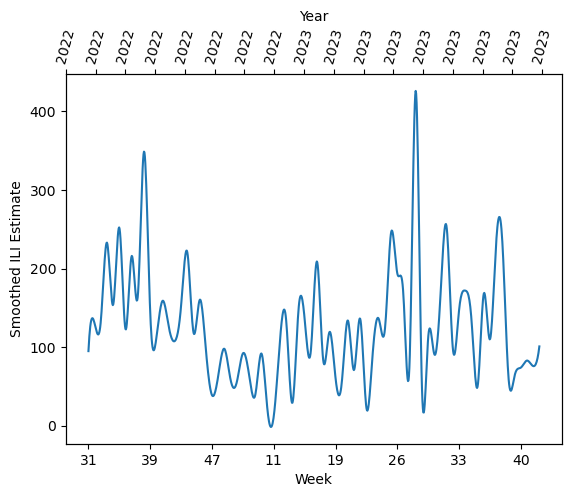

In [18]:
weekly = output[output['year'].isin(['2022', '2023'])]['year-week'].value_counts().sort_index()

x = weekly.reset_index().index
y = weekly.values

X_Y_Spline = make_interp_spline(x, y)

# Returns evenly spaced numbers over a specified interval.
X_ = np.linspace(x.min(), x.max(), 1000)
Y_ = X_Y_Spline(X_)

x_ticks = np.linspace(x.min(), x.max(), len(weekly.index))
x_labels = [str(weekly.index[int(i)] if i < len(weekly.index) else weekly.index[-1]) for i in x_ticks]

# Split the year and the decimal part
x_labels_main = [label.split('-')[1] for label in x_labels]
x_labels_secondary = [label.split('-')[0] for label in x_labels]

fig, ax = plt.subplots()

# Plot your data
ax.plot(X_, Y_)

ax.xaxis.set_major_locator(plt.MaxNLocator(len(x_labels_main[::8])))
ax.xaxis.set_major_formatter(plt.FixedFormatter(x_labels_main[::8]))

# Create a secondary x-axis for the year
ax2 = ax.twiny()
ax2.xaxis.set_major_locator(plt.MaxNLocator(len(x_labels_secondary[::4])))
ax2.xaxis.set_major_formatter(plt.FixedFormatter(x_labels_secondary[::4]))

ax.set_xlabel('Week')
ax2.set_xlabel('Year')

ax.set_ylabel("Smoothed ILI Estimate")

plt.xticks(rotation=75)
plt.show()